# Public Transportation Example using CDF Spark Data Source

In this example notebook, we'll go through some of the features of CDF Spark Data Source for ingesting data into CDF and querying data in CDF. We'll illustrate it on GTFS public transportation schedules. It may be a bit unusual use case for CDF, but it seems to be a good example since the data is non-trivial, while everyone has a basic understanding of bus routes, stops, and schedules.

GTFS is a defacto standard for bus/tram/train schedules and many cities have the dataset publicly available, so you can try it out with your favorite city. It's usually a zip file with a few CSV files. We'll assume you have downloaded your favorite dataset and extracted the data into `gtfs` folder. I have tested this on Prague's data, available here: http://data.pid.cz/PID_GTFS.zip

This is an overview of how the GTFS tables look like:

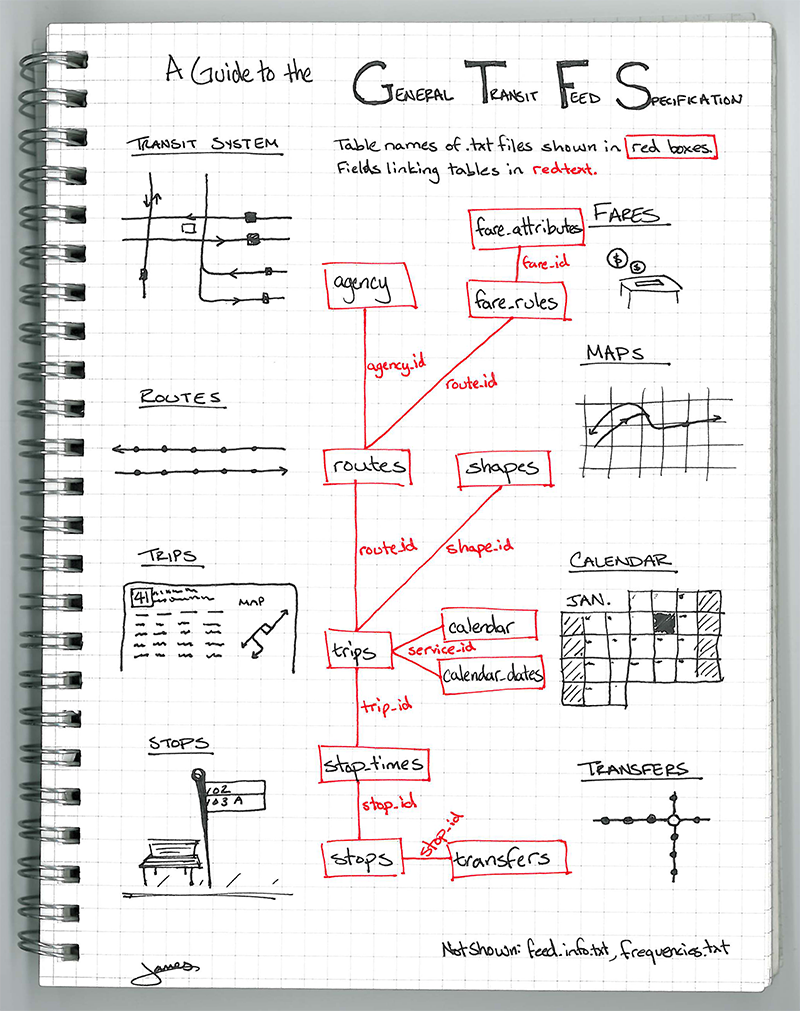

First, we'll have a look at how to ingest the data into CDF. We'll use Spark's built-in CSV support to read the data and CDF data source to write them to the respective resource type.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame
import os

# create session with the CDF data source imported
spark = SparkSession.builder.config("spark.jars.packages","com.cognite.spark.datasource:cdf-spark-datasource_2.12:1.4.26").getOrCreate()
# Assume that the API key is in an environment variable, feel free to replace this with any logic that suites your use case
apikey = os.environ['COGNITE_API_KEY']
#baseUrl = "http://localhost:4001"
baseUrl = "https://greenfield.cognitedata.com"

In [ ]:
# Now let's try to load the CSV. We'll start with the stops table
def loadCsv(table):
    return spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(f"gtfs/{table}.txt")

loadCsv("routes").show()

# for convenience we'll create SQL tables from the csv files
loadCsv("stops").createOrReplaceTempView("stops")
loadCsv("routes").createOrReplaceTempView("routes")
loadCsv("route_stops").createOrReplaceTempView("route_stops")
loadCsv("stop_times").createOrReplaceTempView("stop_times")
loadCsv("trips").createOrReplaceTempView("trips")

In [ ]:
# We'll create a dataset to contain our data
# We won't use spark for that, we'll use the Python SDK instead (since that is just one item)

from cognite.client import CogniteClient
from cognite.client.data_classes import DataSet
client = CogniteClient(api_key = apikey, base_url = baseUrl, client_name='spark-gtfs-example')
dataset = client.data_sets.create(DataSet(name="Public transportation example"))
print(dataset)

## Data Ingestion

Now we are ready to insert some data into the CDF. First, we'll create an asset for each stop, for each route, and for each trip (that means each vehicle moving on a route). Then we'll create events from hops between stops. We'll also create sequences from trips and then add relationships to connects the resources together.

### Inserting Assets

First, let's create a few helper functions for working with CDF. The data source has many options regarding authentication and CDF communication which are mostly the same for all queries, so we'll add a few helpers for it:

In [7]:
def cdfOptions(obj, **options):
    obj.option("apiKey", apikey)
    obj.option("maxRetryDelay", 5) # fail faster during testing
    obj.option("baseUrl", baseUrl)
    obj.option("onconflict", "upsert")
    for k in options:
        obj.option(k, options[k])
    return obj
# Takes a DataFrame and writes it into CDF
def writeToCdf(df, **options):
    cdfOptions(df.write.format("cognite.spark.v1"), **options).save()
# Returns a DataFrame containing data from CDF
def cdfRead(**options):
    return cdfOptions(spark.read.format("cognite.spark.v1"), **options).load()


# Now we are ready to create assets from routes
# This is going to be quite straightforward
routeAssetDf = spark.sql(f"""
    select "route-" || route_id as externalId,
           "Line " || route_short_name as name,
           route_long_name as description,
           {dataset.id} as dataSetId,
           "gtfs-routes" as source,
           map(
               -- translate the number to readable string
               "type", array("tram", "metro", "rail", "bus", "ferry", "cable-tram", "aerial", "funicular", "trolleybus", "monorail")[route_type],
               "url", route_url,
               "is_night", is_night,
               "is_regional", is_regional
           ) as metadata
           from routes
    """)
writeToCdf(routeAssetDf, type="assets")

# We'll add trips as child assets to the routes
tripAssetDf = spark.sql(f"""
    select "trip-" || trip_id as externalId,
           "route-" || route_id as parentExternalId,
           "Trip " || trip_id || " on line " || route_short_name as name,
           "Line " || route_short_name || " to " || trip_headsign as description,
           {dataset.id} as dataSetId,
           "gtfs-trips" as source,
           map(
               "service_id", service_id -- this determines on which day the vehicle goes. We won't use it in the example, but it's important
           ) as metadata
           from trips natural join routes
    """)
writeToCdf(tripAssetDf, type="assets")

We have just inserted one asset for each route + one for each trip on that line. We can already use CDF to explore part of our data set. For example, I found out there is 7 ferries in Prague and specifically the P1 line goes 91 times per day
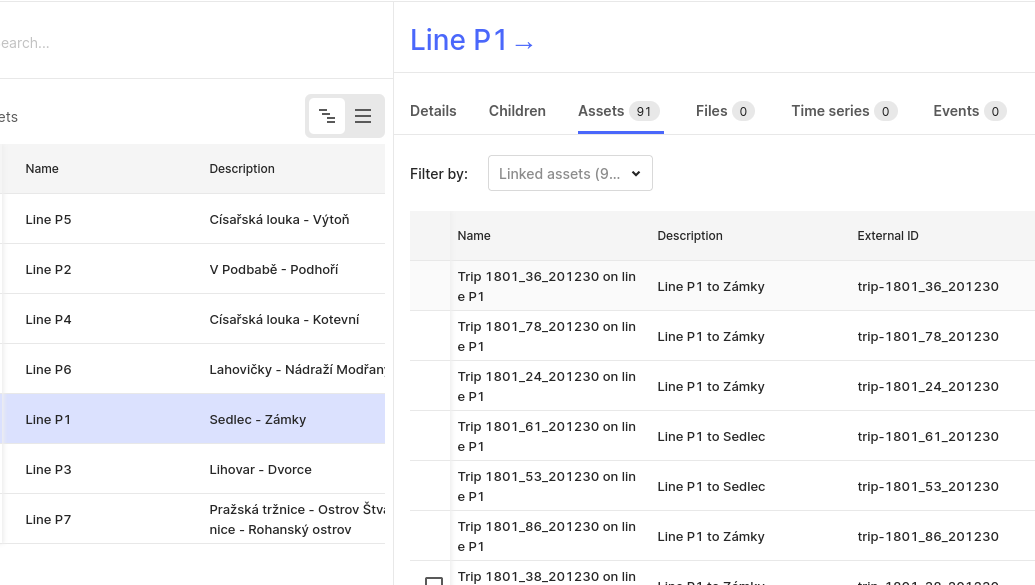

### Inserting Asset Hierarchy 

Now we'll ingest the stops. For the reason of not being super boring, we'll transform the data a bit first. There is a problem that many stops have several platforms and these platforms are represented as separate stops in the GTFS table. We'll join them by creating one asset for the entire station and then one child asset for each platform on that stop.

One more complication is that the stops are in a hierarchy - for each stop, there may be a parent_station defined. We'd like to preserve this in the asset hierarchy, so we'll set the parentId accordingly. We'll use the `assethierarchy` type for the second step to ensure that hierarchies are inserted in the right order.

In [5]:
# First, let's add the stop Asset for each stop name
stopNamesDf = spark.sql(f"""
    select --"stop-" || regexp_replace(name, '( |,)', '_') as externalId,
           "stop-" || name as externalId,
           "Stop " || name as name,
           {dataset.id} as dataSetId,
           "gtfs-stops" as source
           from (select distinct stop_name as name from stops where stop_name is not null)
    """)
writeToCdf(stopNamesDf, type="assets")

# Then, we'll add the second layer - the actual platforms of the stops
stopPlatformsDf = spark.sql(f"""
    select "stop-platform-" || stop_id as externalId,
           "Stop " || stop_name || " " || stop_id as name,
           {dataset.id} as dataSetId,
           "gtfs-stops" as source,
           -- parent is the Stop name asset unless specified otherwise
           -- if(parent_station is null, "stop-" || stop_name, "stop-platform-" || parent_station) as parentExternalId,
           "stop-" || stop_name as parentExternalId,
           map(
               'pos-lon', string(stop_lon),
               'pos-lat', string(stop_lat),
               'wheelchair-boarding', string(wheelchair_boarding)
           ) as metadata
           from stops
           where stop_name is not null
    """)
writeToCdf(stopPlatformsDf, type="assets") # TODO: assethierarchy is buggy and can not handle this number of assets, fix this

Inserting into the other resource types is very similar to assets, there are just slightly different columns, so we will go through it a bit faster.

### Inserting Events

The next step is events - an event has a start and end and is connected to an asset. We will insert an event for each move of a vehicle from one station to another.

This data is in the stop_times, but in a slightly different format - it says when a vehicle is on a stop, but we want to store events when does the vehicle move from one stop to another. So we'll do a join with itself on `from.stop_sequence = to.stop_sequence - 1`.

There is one last detail, which makes creating events a little more complicated - we want to link them to the assets we just created - the routes and stops. Unfortunately, we have to specify the internal id of the asset, externalIds are not supported here. We'll get around this limitation by JOINing in the created assets. Note that while doing the join we specify a filter on `datasetId` and `source` which seem redundant at first, but these make the execution time significantly faster as the filter is evaluated in CDF before the data is fetched. It is recommended to put known information (such as datasetId, source, label, or some metadata) into the filters, especially when doing JOINs.

In [ ]:
ourAssets = cdfRead(type="assets").filter(f"dataSetId = {dataset.id}")
ourAssets.createOrReplaceTempView("cdf_assets")
moveEvents = spark.sql(f"""
    select "move-" || fromT.trip_id || ":" || fromT.stop_sequence as externalId,
           format_string("Line %s moves from %s to %s at %s", route.route_short_name, fromS.stop_name, toS.stop_name, toT.arrival_time) as description,
           {dataset.id} as dataSetId,
           "gtfs-moves" as source,
           array(
               fromPlatform.id,
               fromPlatform.rootId,
               toPlatform.id,
               toPlatform.rootId,
               trip.id
           ) as assetIds,
           'transport-move' as type,
           timestamp(toT.arrival_time) as endTime,
           timestamp(fromT.departure_time) as startTime,
           map(
               "routeId", route.route_id,
               "routeName", route.route_short_name,
               "from", fromS.stop_id,
               "fromName", fromS.stop_name,
               "to", toS.stop_id,
               "toName", toS.stop_name,
               "tripId", fromT.trip_id,
               "toTime", toT.arrival_time,
               "fromTime", fromT.departure_time
           ) as metadata

           from stop_times fromT
           -- join from and to stop_times
           join stop_times toT on fromT.stop_sequence = toT.stop_sequence - 1 
                                  and fromT.trip_id = toT.trip_id
           -- also join in the information about the stops
           join stops fromS on fromS.stop_id = fromT.stop_id
           join stops toS on toS.stop_id = toT.stop_id
           -- and some info about the route
           join trips trip on toT.trip_id = trip.trip_id
           join routes route on trip.route_id = route.route_id
           
           -- join in the asset ids
           join cdf_assets fromPlatform on fromPlatform.externalId = "stop-platform-" || fromS.stop_id
           join cdf_assets toPlatform   on   toPlatform.externalId = "stop-platform-" ||   toS.stop_id
           join cdf_assets trip         on         trip.externalId = "trip-" || fromT.trip_id
           
           -- just ignore weird data, it's only an example
           where timestamp(fromT.departure_time) is not null
           -- and filters for pushdown to CDF
             and fromPlatform.source = "gtfs-stops"
             and   toPlatform.source = "gtfs-stops"
             and         trip.source = "gtfs-trips"
    """)
writeToCdf(moveEvents, type="events")

In the data explorer we can see that the events were created successfully:

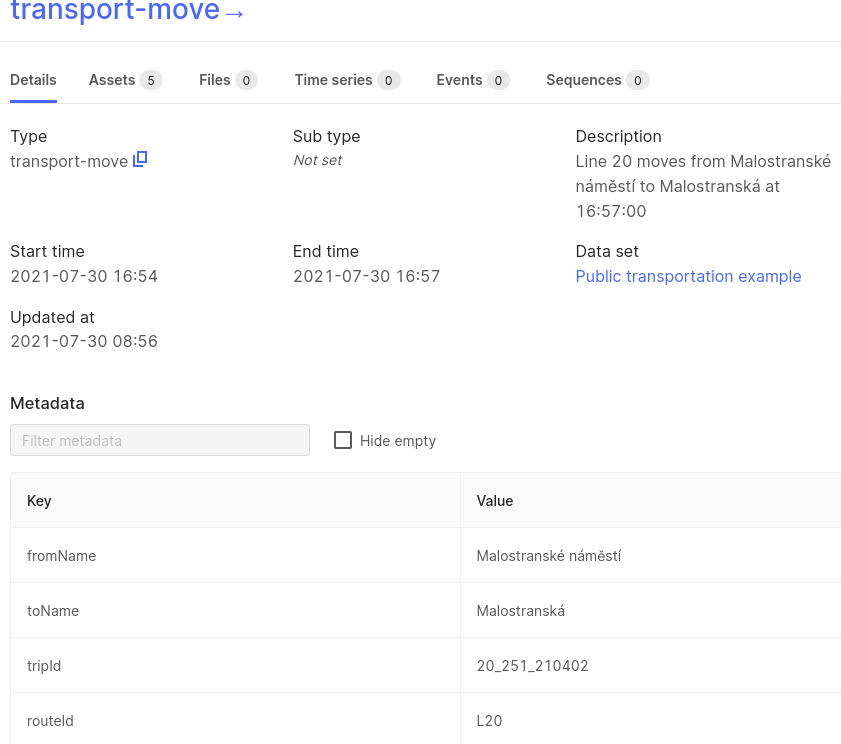

And that they are correctly linked to the assets:
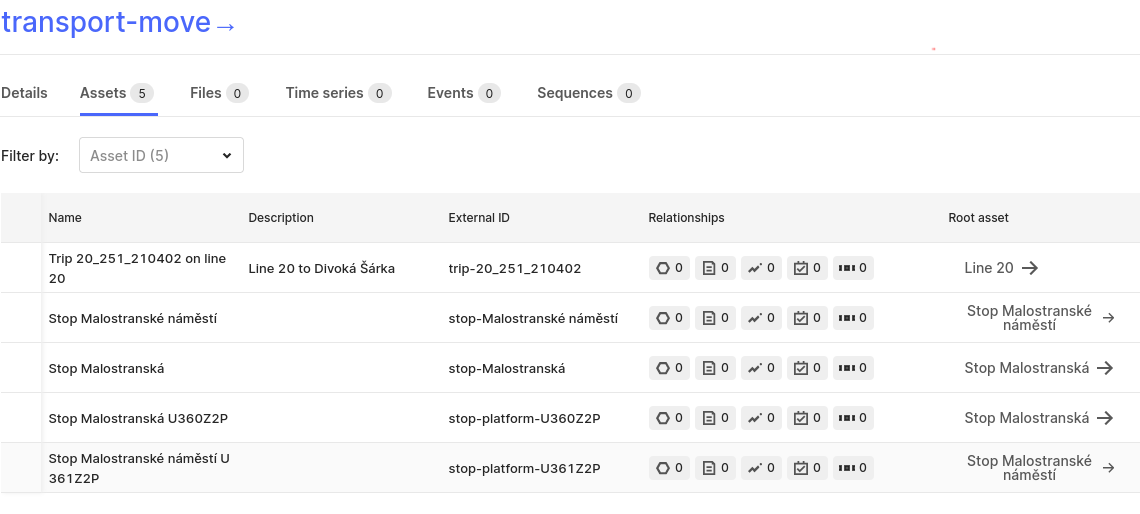

## Querying data

I'd say that querying the data in CDF is comparatively easier than inserting it. I always wanted to have a panel at home that would be showing when are trams going to be at our nearest stop and now I can finally use CDF to make my dream a reality :) We'll a simple SQL query for that.

First, we'll create temporary views from the CDF resources, then just filter events in the future and order them by the date of departure.

In [21]:
cdfEvents = cdfRead(type="events").filter(f"dataSetId = {dataset.id}")
cdfEvents.createOrReplaceTempView("cdf_events")

spark.sql("""
    select event.description as moveDescription,
           trip.description as tripDescription,
           event.metadata.toName as nextStop,
           event.metadata.fromName as stop,
           event.startTime as time
    from cdf_events event
    join cdf_assets trip on "trip-" || event.metadata.tripId = trip.externalId
    
    -- leaving from my nearest stop in Prague
    where event.metadata.fromName = "Drinopol"
      and event.startTime > now()
      
    order by event.startTime
""").show()

+--------------------+--------------------+---------+--------+-------------------+
|     moveDescription|     tripDescription| nextStop|    stop|               time|
+--------------------+--------------------+---------+--------+-------------------+
|Line 25 moves fro...|Line 25 to Bílá Hora|U Kaštanu|Drinopol|2021-07-30 09:46:00|
|Line 25 moves fro...|  Line 25 to Lehovec| Marjánka|Drinopol|2021-07-30 09:50:00|
|Line 22 moves fro...|Line 22 to Staré ...| Marjánka|Drinopol|2021-07-30 09:51:00|
|Line 33 moves fro...|Line 33 to Malost...| Marjánka|Drinopol|2021-07-30 09:52:00|
|Line 33 moves fro...|Line 33 to Bílá Hora|U Kaštanu|Drinopol|2021-07-30 09:57:00|
|Line 33 moves fro...|Line 33 to Malost...| Marjánka|Drinopol|2021-07-30 09:58:00|
|Line 33 moves fro...|Line 33 to Malost...| Marjánka|Drinopol|2021-07-30 10:10:00|
|Line 22 moves fro...|Line 22 to Staré ...| Marjánka|Drinopol|2021-07-30 10:14:00|
|Line 25 moves fro...|  Line 25 to Lehovec| Marjánka|Drinopol|2021-07-30 10:20:00|
|Lin

## Inserting into RAW

Let's say we'd like to import the CSV files as is and process them later in CDF (for example using SQL transformations). For that, we can use RAW. Inserting data into RAW is quite simple, because don't have to do any transformation, the only requirement is to choose one column as the key.

The special thing about RAW is that the schema is not fixed like it's the case with assets, events, and other standard CDF resources. We'll have to adjust our write function for that, so we'll create a special function for ingesting RAW rows.

In [ ]:
def loadIntoRaw(database, table, source: DataFrame):
    # RAW is a bit special since it does not have a fixed schema
    # When writing, we order it to use the same schema as the source dataset
    destinationBuilder = cdfOptions(
        spark.read.format("cognite.spark.v1"),
        inferSchema=False,
        database=database,
        table=table,
        type="raw"
    )
    destination = destinationBuilder.schema(source.schema).load()
    destination.createOrReplaceTempView("destinationRawTable")
    source.select(*destination.columns).write.insertInto("destinationRawTable")

# Note that the RAW tables must be created before this script is executed.
# In case manual creation is not feasible, Python SDK can be used for this
loadIntoRaw("gtfs-example", "stops",
    spark.sql("select *, stop_id as key from stops")
)
loadIntoRaw("gtfs-example", "routes",
    spark.sql("select *, route_id as key from routes")
)
loadIntoRaw("gtfs-example", "trips",
    spark.sql("select *, trip_id as key from trips")
)
loadIntoRaw("gtfs-example", "stop_times",
    spark.sql("select *, trip_id || ':' || stop_sequence as key from stop_times")
)